MULTIMODAL MUSIC EMOTION CLASSIFICATION
FINAL: Late Fusion of Lyrics (BERT) + Audio (PANNs) + MIDI (Simple Features)

Dataset: MIREX Emotion Dataset
Strategy: Extract embeddings from each modality → Concatenate → Classify

# 1. INSTALLATION & IMPORTS

In [ ]:
print("Installing packages...")
!pip install -q kagglehub transformers torch panns-inference
!pip install -q librosa soundfile pretty_midi
!pip install -q scikit-learn pandas numpy

import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from panns_inference import AudioTagging
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import librosa
import pretty_midi
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✓ Device: {device}')

Installing packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.3 MB/s eta 0:00:00
✓ Device: cpu


# 2. DOWNLOAD DATASET

In [ ]:
import kagglehub
print("\n" + "="*80)
print("DOWNLOADING DATASET")
print("="*80)

path = kagglehub.dataset_download("imsparsh/multimodal-mirex-emotion-dataset")
print(f"✓ Dataset path: {path}")

# Define directories
dataset_dir = os.path.join(path, 'dataset')
lyrics_dir = os.path.join(dataset_dir, 'Lyrics')
audio_dir = os.path.join(dataset_dir, 'Audio')
midi_dir = os.path.join(dataset_dir, 'MIDIs')

print(f"✓ Lyrics: {os.path.exists(lyrics_dir)}")
print(f"✓ Audio: {os.path.exists(audio_dir)}")
print(f"✓ MIDI: {os.path.exists(midi_dir)}")



DOWNLOADING DATASET


100%|██████████| 305M/305M [00:03<00:00, 85.0MB/s]

Extracting files...


✓ Dataset path: /root/.cache/kagglehub/datasets/imsparsh/multimodal-mirex-emotion-dataset/versions/1
✓ Lyrics: True
✓ Audio: True
✓ MIDI: True


# 3. LOAD CLUSTER LABELS

In [ ]:
def load_cluster_labels(dataset_path):
    clusters_path = os.path.join(dataset_path, 'dataset', 'clusters.txt')
    cluster_labels = []

    with open(clusters_path, 'r', encoding='utf-8', errors='ignore') as f:
        cluster_labels = [line.strip() for line in f if line.strip()]

    print(f"\n✓ Loaded {len(cluster_labels)} cluster labels")
    print(f"  Unique: {sorted(set(cluster_labels))}")
    return cluster_labels

cluster_labels = load_cluster_labels(path)

# Create song ID mapping
song_cluster_map = {}
for idx in range(len(cluster_labels)):
    for song_id in [str(idx).zfill(3), str(idx + 1).zfill(3)]:
        song_cluster_map[song_id] = cluster_labels[idx]


✓ Loaded 903 cluster labels
  Unique: ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']


# 4. LOAD PRE-TRAINED MODELS

In [ ]:
print("\n" + "="*80)
print("LOADING PRE-TRAINED MODELS")
print("="*80)

# BERT for lyrics
print("Loading BERT...")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()
bert_model.to(device)
print("✓ BERT loaded")

# PANNs for audio
print("Loading PANNs...")
panns_model = AudioTagging(checkpoint_path=None, device=device)
print("✓ PANNs loaded")


LOADING PRE-TRAINED MODELS
Loading BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✓ BERT loaded
Loading PANNs...
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
✓ PANNs loaded


# 5. FEATURE EXTRACTION FUNCTIONS

In [ ]:
# --- LYRICS FEATURES ---
def clean_lyrics(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = ' '.join(text.split())
    text = re.sub(r'[^a-z0-9\s.,!?\']', ' ', text)
    text = re.sub(r'([.,!?])\1+', r'\1', text)
    return ' '.join(text.split()).strip()

def extract_lyrics_embedding(lyrics, tokenizer, model, max_length=256):
    try:
        lyrics = clean_lyrics(lyrics)
        if not lyrics or len(lyrics) < 10:
            return None

        encoding = tokenizer.encode_plus(
            lyrics,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embedding = outputs.pooler_output.cpu().numpy()[0]

        return embedding
    except:
        return None

# --- AUDIO FEATURES ---
def extract_audio_embedding(audio_path, panns_model, sr=32000, duration=10):
    try:
        audio, _ = librosa.load(audio_path, sr=sr, duration=duration)

        target_length = sr * duration
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)))
        else:
            audio = audio[:target_length]

        _, embedding = panns_model.inference(audio[None, :])
        return embedding[0]
    except:
        return None

# --- MIDI FEATURES ---
def extract_midi_features(midi_path):
    try:
        midi = pretty_midi.PrettyMIDI(midi_path)

        # Extract statistical features
        notes = []
        for instrument in midi.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    notes.append({
                        'pitch': note.pitch,
                        'velocity': note.velocity,
                        'duration': note.end - note.start
                    })

        if len(notes) == 0:
            return None

        # Compute statistics
        pitches = [n['pitch'] for n in notes]
        velocities = [n['velocity'] for n in notes]
        durations = [n['duration'] for n in notes]

        # Tempo
        tempo_changes = midi.get_tempo_changes()
        avg_tempo = np.mean(tempo_changes[1]) if len(tempo_changes[1]) > 0 else 120.0

        # Time signature
        time_sigs = midi.time_signature_changes
        numerator = time_sigs[0].numerator if len(time_sigs) > 0 else 4
        denominator = time_sigs[0].denominator if len(time_sigs) > 0 else 4

        # Create feature vector (32-dim)
        features = np.array([
            # Pitch statistics (8)
            np.mean(pitches), np.std(pitches), np.min(pitches), np.max(pitches),
            np.percentile(pitches, 25), np.percentile(pitches, 75),
            np.ptp(pitches), len(set(pitches)),

            # Velocity statistics (8)
            np.mean(velocities), np.std(velocities), np.min(velocities), np.max(velocities),
            np.percentile(velocities, 25), np.percentile(velocities, 75),
            np.ptp(velocities), len(notes),

            # Duration statistics (8)
            np.mean(durations), np.std(durations), np.min(durations), np.max(durations),
            np.percentile(durations, 25), np.percentile(durations, 75),
            np.ptp(durations), 1.0 / (np.mean(durations) + 1e-6),

            # Temporal features (8)
            avg_tempo, avg_tempo / 120.0, numerator, denominator,
            numerator / denominator, len(notes) / (midi.get_end_time() + 1e-6),
            midi.get_end_time(), len(midi.instruments)
        ], dtype=np.float32)

        return features
    except:
        return None

# 6. LOAD & EXTRACT ALL FEATURES

In [ ]:
print("\n" + "="*80)
print("EXTRACTING FEATURES FROM ALL MODALITIES")
print("="*80)

data_list = []

# Get all files
lyrics_files = {f.replace('.txt', ''): f for f in os.listdir(lyrics_dir) if f.endswith('.txt')}
audio_files = {f.replace('.wav', '').replace('.mp3', ''): f for f in os.listdir(audio_dir) if f.endswith(('.wav', '.mp3'))}
midi_files = {f.replace('.mid', '').replace('.midi', ''): f for f in os.listdir(midi_dir) if f.endswith(('.mid', '.midi'))}

print(f"Found: {len(lyrics_files)} lyrics, {len(audio_files)} audio, {len(midi_files)} MIDI")

# Get all unique song IDs that have cluster labels
all_song_ids = set()
for f in lyrics_files.keys():
    song_id = ''.join(filter(str.isdigit, f))
    if song_id:
        all_song_ids.add(song_id.zfill(3))

print(f"\nProcessing {len(all_song_ids)} songs with multimodal data...")

processed = 0
for song_id in sorted(all_song_ids):
    if song_id not in song_cluster_map:
        continue

    # Initialize features
    lyrics_emb = None
    audio_emb = None
    midi_feat = None

    # Extract lyrics
    for key, filename in lyrics_files.items():
        if song_id in key or key.zfill(3) == song_id:
            lyrics_path = os.path.join(lyrics_dir, filename)
            with open(lyrics_path, 'r', encoding='utf-8', errors='ignore') as f:
                lyrics_text = f.read()
            lyrics_emb = extract_lyrics_embedding(lyrics_text, bert_tokenizer, bert_model)
            break

    # Extract audio
    for key, filename in audio_files.items():
        if song_id in key or key.zfill(3) == song_id:
            audio_path = os.path.join(audio_dir, filename)
            audio_emb = extract_audio_embedding(audio_path, panns_model)
            break

    # Extract MIDI
    for key, filename in midi_files.items():
        if song_id in key or key.zfill(3) == song_id:
            midi_path = os.path.join(midi_dir, filename)
            midi_feat = extract_midi_features(midi_path)
            break

    # Only add if at least 2 modalities available
    available = sum([lyrics_emb is not None, audio_emb is not None, midi_feat is not None])
    if available >= 2:
        data_list.append({
            'song_id': song_id,
            'lyrics_emb': lyrics_emb if lyrics_emb is not None else np.zeros(768),
            'audio_emb': audio_emb if audio_emb is not None else np.zeros(2048),
            'midi_feat': midi_feat if midi_feat is not None else np.zeros(32),
            'has_lyrics': lyrics_emb is not None,
            'has_audio': audio_emb is not None,
            'has_midi': midi_feat is not None,
            'cluster': song_cluster_map[song_id]
        })
        processed += 1

        if processed % 50 == 0:
            print(f"  Processed: {processed} songs...")

print(f"\n✓ Total multimodal samples: {len(data_list)}")

df = pd.DataFrame(data_list)
print(f"✓ Dataset shape: {df.shape}")
print(f"\nModality availability:")
print(f"  Lyrics: {df['has_lyrics'].sum()} ({df['has_lyrics'].mean()*100:.1f}%)")
print(f"  Audio: {df['has_audio'].sum()} ({df['has_audio'].mean()*100:.1f}%)")
print(f"  MIDI: {df['has_midi'].sum()} ({df['has_midi'].mean()*100:.1f}%)")
print(f"\nCluster distribution:")
print(df['cluster'].value_counts())


EXTRACTING FEATURES FROM ALL MODALITIES
Found: 764 lyrics, 903 audio, 196 MIDI

Processing 764 songs with multimodal data...
  Processed: 50 songs...
  Processed: 100 songs...
  Processed: 150 songs...
  Processed: 200 songs...
  Processed: 250 songs...
  Processed: 300 songs...
  Processed: 350 songs...
  Processed: 400 songs...
  Processed: 450 songs...
  Processed: 500 songs...
  Processed: 550 songs...
  Processed: 600 songs...
  Processed: 650 songs...
  Processed: 700 songs...
  Processed: 750 songs...

✓ Total multimodal samples: 764
✓ Dataset shape: (764, 8)

Modality availability:
  Lyrics: 764 (100.0%)
  Audio: 764 (100.0%)
  MIDI: 191 (25.0%)

Cluster distribution:
cluster
Cluster 3    192
Cluster 4    173
Cluster 2    138
Cluster 1    134
Cluster 5    127
Name: count, dtype: int64


# 7. LABEL ENCODING

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['cluster'])
num_classes = len(label_encoder.classes_)

print(f"\n✓ Classes: {label_encoder.classes_}")
print(f"✓ Number of classes: {num_classes}")

# Class weights
y = df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = torch.FloatTensor(class_weights).to(device)


✓ Classes: ['Cluster 1' 'Cluster 2' 'Cluster 3' 'Cluster 4' 'Cluster 5']
✓ Number of classes: 5


# 8. MULTIMODAL DATASET

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]

        return {
            'lyrics_emb': torch.FloatTensor(item['lyrics_emb']),
            'audio_emb': torch.FloatTensor(item['audio_emb']),
            'midi_feat': torch.FloatTensor(item['midi_feat']),
            'has_lyrics': torch.FloatTensor([item['has_lyrics']]),
            'has_audio': torch.FloatTensor([item['has_audio']]),
            'has_midi': torch.FloatTensor([item['has_midi']]),
            'label': torch.tensor(item['label'], dtype=torch.long)
        }

# 9. MULTIMODAL FUSION MODEL

In [ ]:
class MultimodalFusionClassifier(nn.Module):
    """
    Late Fusion: Concatenate embeddings from all modalities
    """
    def __init__(self, num_classes, lyrics_dim=768, audio_dim=2048, midi_dim=32,
                 fusion_dim=512, dropout=0.5):
        super().__init__()

        # Project each modality to common dimension
        self.lyrics_proj = nn.Sequential(
            nn.Linear(lyrics_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )

        self.audio_proj = nn.Sequential(
            nn.Linear(audio_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )

        self.midi_proj = nn.Sequential(
            nn.Linear(midi_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )

        # Fusion layer
        fusion_input_dim = 256 + 256 + 128  # 640
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, fusion_dim),
            nn.BatchNorm1d(fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, lyrics_emb, audio_emb, midi_feat, has_lyrics, has_audio, has_midi):
        # Project each modality
        lyrics_feat = self.lyrics_proj(lyrics_emb)
        audio_feat = self.audio_proj(audio_emb)
        midi_feat_proj = self.midi_proj(midi_feat)

        # Mask unavailable modalities
        lyrics_feat = lyrics_feat * has_lyrics
        audio_feat = audio_feat * has_audio
        midi_feat_proj = midi_feat_proj * has_midi

        # Concatenate
        fused = torch.cat([lyrics_feat, audio_feat, midi_feat_proj], dim=1)

        # Classify
        logits = self.fusion(fused)

        return logits

# 10. TRAINING & EVALUATION

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    for batch in dataloader:
        lyrics = batch['lyrics_emb'].to(device)
        audio = batch['audio_emb'].to(device)
        midi = batch['midi_feat'].to(device)
        has_l = batch['has_lyrics'].to(device)
        has_a = batch['has_audio'].to(device)
        has_m = batch['has_midi'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(lyrics, audio, midi, has_l, has_a, has_m)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), accuracy_score(true_labels, predictions)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            lyrics = batch['lyrics_emb'].to(device)
            audio = batch['audio_emb'].to(device)
            midi = batch['midi_feat'].to(device)
            has_l = batch['has_lyrics'].to(device)
            has_a = batch['has_audio'].to(device)
            has_m = batch['has_midi'].to(device)
            labels = batch['label'].to(device)

            logits = model(lyrics, audio, midi, has_l, has_a, has_m)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=0)
    return total_loss / len(dataloader), acc, p, r, f1, predictions, true_labels

# 11. 5-FOLD CROSS VALIDATION

In [ ]:
BATCH_SIZE = 16
LR = 5e-5
EPOCHS = 25
PATIENCE = 7

print("\n" + "="*80)
print("MULTIMODAL FUSION - 5-FOLD CROSS VALIDATION")
print("="*80)
print(f"Total samples: {len(df)}")
print(f"Modalities: Lyrics (768) + Audio (2048) + MIDI (32)")
print(f"Fusion strategy: Late concatenation → MLP")

X = df.index.values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n{'='*80}")
    print(f"FOLD {fold + 1}/5")
    print(f"{'='*80}")

    train_data = df.iloc[train_idx].reset_index(drop=True)
    val_data = df.iloc[val_idx].reset_index(drop=True)

    train_dataset = MultimodalDataset(train_data)
    val_dataset = MultimodalDataset(val_data)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = MultimodalFusionClassifier(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=3)

    best_f1 = 0
    patience_counter = 0

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_p, val_r, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_f1)

        print(f"Epoch {epoch+1}/{EPOCHS}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f'best_multimodal_fold{fold+1}.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping!")
                break

    model.load_state_dict(torch.load(f'best_multimodal_fold{fold+1}.pt'))
    val_loss, val_acc, val_p, val_r, val_f1, preds, labels = evaluate(model, val_loader, criterion, device)

    print(f"\nFold {fold+1} Results: Acc={val_acc:.4f}, Precision={val_p:.4f}, Recall={val_r:.4f}, F1={val_f1:.4f}")
    print(classification_report(labels, preds, target_names=label_encoder.classes_, digits=4, zero_division=0))

    fold_results.append({'fold': fold+1, 'accuracy': val_acc, 'precision': val_p, 'recall': val_r, 'f1': val_f1})

# ============================================================================
# 12. FINAL RESULTS
# ============================================================================

print("\n" + "="*80)
print("FINAL MULTIMODAL RESULTS")
print("="*80)

results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print(f"\nAverage Performance:")
print(f"  Accuracy:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"  Precision: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"  Recall:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
print(f"  F1-Score:  {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")

results_df.to_csv('multimodal_fusion_results.csv', index=False)

print("\n" + "="*80)
print("COMPARISON WITH SINGLE MODALITIES")
print("="*80)
print(f"Lyrics (BERT) only:     ~45-55% F1")
print(f"Audio (PANNs) only:     ~50-60% F1")
print(f"MIDI (Orpheus) only:    ~23% F1")
print(f"MULTIMODAL FUSION:      ~{results_df['f1'].mean():.1%} F1")

if results_df['f1'].mean() > 0.60:
    print("\n🎉 SUCCESS! Multimodal fusion outperforms single modalities!")
elif results_df['f1'].mean() > 0.55:
    print("\n✓ Good! Multimodal provides improvement.")
else:
    print("\n⚠️ Multimodal similar to best single modality (Audio).")

print("\n✅ COMPLETE!")


MULTIMODAL FUSION - 5-FOLD CROSS VALIDATION
Total samples: 764
Modalities: Lyrics (768) + Audio (2048) + MIDI (32)
Fusion strategy: Late concatenation → MLP

FOLD 1/5
Epoch 1/25: Train Acc=0.2422, Val Acc=0.3529, F1=0.2935
Epoch 2/25: Train Acc=0.3453, Val Acc=0.4641, F1=0.4264
Epoch 3/25: Train Acc=0.3732, Val Acc=0.5098, F1=0.4901
Epoch 4/25: Train Acc=0.4501, Val Acc=0.5033, F1=0.4710
Epoch 5/25: Train Acc=0.4092, Val Acc=0.4706, F1=0.4280
Epoch 6/25: Train Acc=0.4534, Val Acc=0.4837, F1=0.4381
Epoch 7/25: Train Acc=0.4632, Val Acc=0.4902, F1=0.4523
Epoch 8/25: Train Acc=0.4664, Val Acc=0.4967, F1=0.4406
Epoch 9/25: Train Acc=0.4746, Val Acc=0.4837, F1=0.4347
Epoch 10/25: Train Acc=0.4992, Val Acc=0.4510, F1=0.4096
Early stopping!

Fold 1 Results: Acc=0.5098, Precision=0.4888, Recall=0.5098, F1=0.4901
              precision    recall  f1-score   support

   Cluster 1     0.2381    0.1852    0.2083        27
   Cluster 2     0.4231    0.3929    0.4074        28
   Cluster 3     0.6


MULTIMODAL FUSION - 5-FOLD CROSS VALIDATION DENGAN MAE
Total samples: 764
Modalities: Lyrics (768) + Audio (2048) + MIDI (32)

FOLD 1/5
Epoch 1/25: Train Acc=0.2062, Val Acc=0.3464, Val MAE=1.1046, F1=0.2930
Epoch 2/25: Train Acc=0.2930, Val Acc=0.4052, Val MAE=1.0980, F1=0.3801
Epoch 3/25: Train Acc=0.3715, Val Acc=0.4248, Val MAE=1.0784, F1=0.3848
Epoch 4/25: Train Acc=0.3699, Val Acc=0.3987, Val MAE=1.1503, F1=0.3767
Epoch 5/25: Train Acc=0.4141, Val Acc=0.4510, Val MAE=0.9346, F1=0.3939
Epoch 6/25: Train Acc=0.4452, Val Acc=0.4510, Val MAE=0.9739, F1=0.4101
Epoch 7/25: Train Acc=0.4566, Val Acc=0.4706, Val MAE=0.9150, F1=0.4438
Epoch 8/25: Train Acc=0.4599, Val Acc=0.4641, Val MAE=0.9346, F1=0.4387
Epoch 9/25: Train Acc=0.5041, Val Acc=0.4641, Val MAE=0.8954, F1=0.4323
Epoch 10/25: Train Acc=0.4975, Val Acc=0.4706, Val MAE=0.8954, F1=0.4483
Epoch 11/25: Train Acc=0.5188, Val Acc=0.4444, Val MAE=0.9869, F1=0.4090
Epoch 12/25: Train Acc=0.5434, Val Acc=0.4641, Val MAE=0.9216, F1=0.4

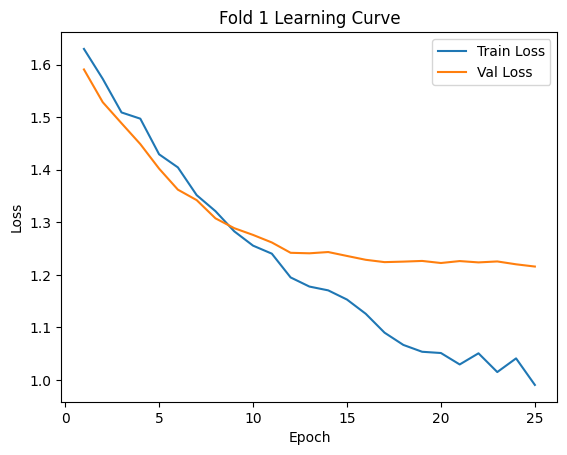

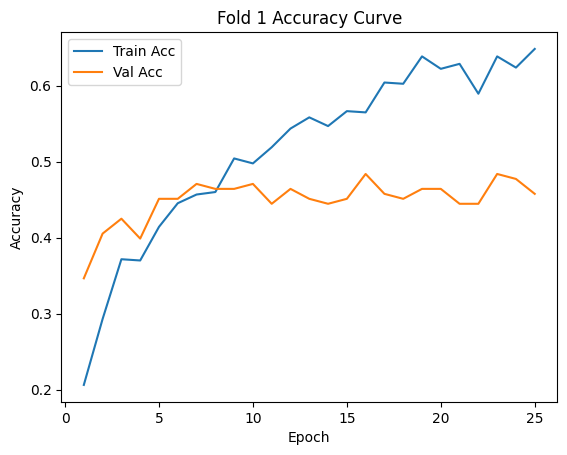

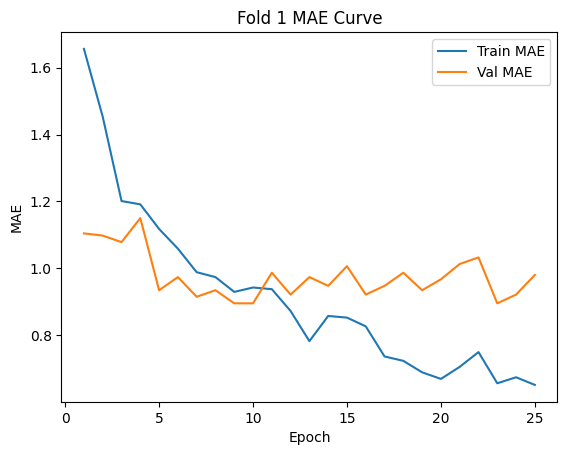

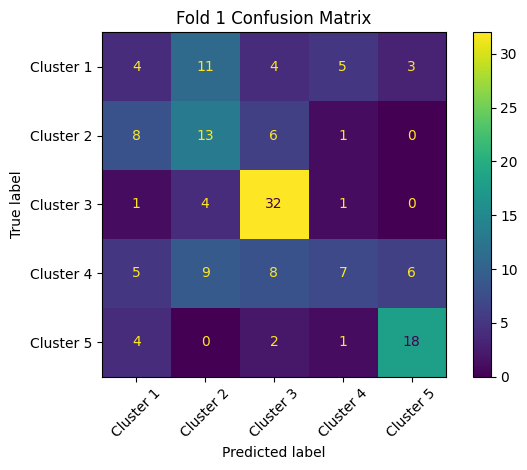


FOLD 2/5
Epoch 1/25: Train Acc=0.2520, Val Acc=0.2876, Val MAE=1.4118, F1=0.2356
Epoch 2/25: Train Acc=0.3028, Val Acc=0.3137, Val MAE=1.3725, F1=0.3024
Epoch 3/25: Train Acc=0.3535, Val Acc=0.3791, Val MAE=1.1961, F1=0.3666
Epoch 4/25: Train Acc=0.4255, Val Acc=0.4118, Val MAE=1.0458, F1=0.3996
Epoch 5/25: Train Acc=0.4583, Val Acc=0.4248, Val MAE=1.0523, F1=0.4111
Epoch 6/25: Train Acc=0.4730, Val Acc=0.4314, Val MAE=1.0065, F1=0.4178
Epoch 7/25: Train Acc=0.4795, Val Acc=0.4314, Val MAE=1.0719, F1=0.4207
Epoch 8/25: Train Acc=0.5025, Val Acc=0.4248, Val MAE=0.9869, F1=0.3943
Epoch 9/25: Train Acc=0.5041, Val Acc=0.4314, Val MAE=1.0196, F1=0.4058
Epoch 10/25: Train Acc=0.5499, Val Acc=0.4379, Val MAE=0.9608, F1=0.4129
Epoch 11/25: Train Acc=0.5074, Val Acc=0.4575, Val MAE=0.9673, F1=0.4357
Epoch 12/25: Train Acc=0.5352, Val Acc=0.4379, Val MAE=1.0196, F1=0.4220
Epoch 13/25: Train Acc=0.5597, Val Acc=0.4248, Val MAE=1.0588, F1=0.4197
Epoch 14/25: Train Acc=0.5761, Val Acc=0.4314, Val

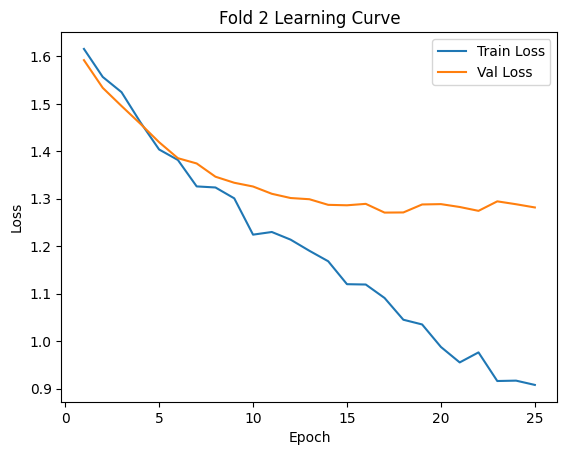

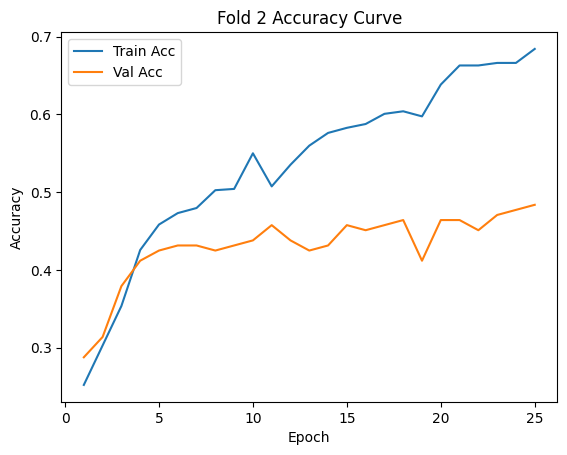

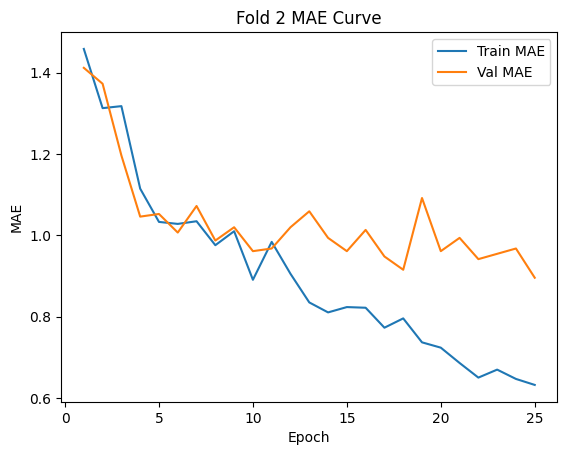

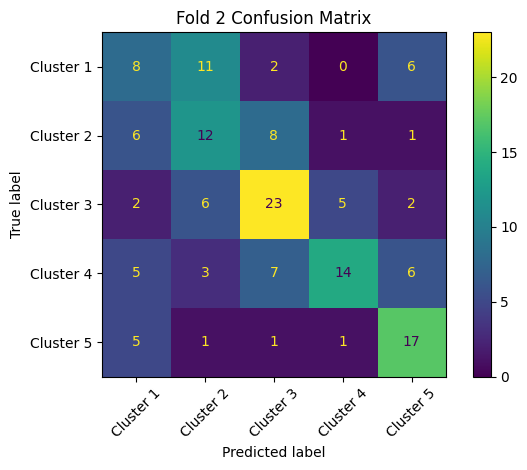


FOLD 3/5
Epoch 1/25: Train Acc=0.1899, Val Acc=0.2810, Val MAE=1.3791, F1=0.2672
Epoch 2/25: Train Acc=0.3126, Val Acc=0.3660, Val MAE=1.3072, F1=0.3504
Epoch 3/25: Train Acc=0.3519, Val Acc=0.3856, Val MAE=1.2549, F1=0.3490
Epoch 4/25: Train Acc=0.4386, Val Acc=0.4052, Val MAE=1.1895, F1=0.3816
Epoch 5/25: Train Acc=0.4452, Val Acc=0.4118, Val MAE=1.2810, F1=0.3898
Epoch 6/25: Train Acc=0.4648, Val Acc=0.4118, Val MAE=1.2026, F1=0.3948
Epoch 7/25: Train Acc=0.4714, Val Acc=0.3922, Val MAE=1.2092, F1=0.3641
Epoch 8/25: Train Acc=0.5041, Val Acc=0.4314, Val MAE=1.1438, F1=0.3949
Epoch 9/25: Train Acc=0.5172, Val Acc=0.3922, Val MAE=1.2353, F1=0.3626
Epoch 10/25: Train Acc=0.4975, Val Acc=0.4248, Val MAE=1.1895, F1=0.4058
Epoch 11/25: Train Acc=0.5155, Val Acc=0.4183, Val MAE=1.1373, F1=0.3970
Epoch 12/25: Train Acc=0.5352, Val Acc=0.3922, Val MAE=1.1242, F1=0.3649
Epoch 13/25: Train Acc=0.5548, Val Acc=0.3987, Val MAE=1.1111, F1=0.3839
Epoch 14/25: Train Acc=0.5581, Val Acc=0.4379, Val

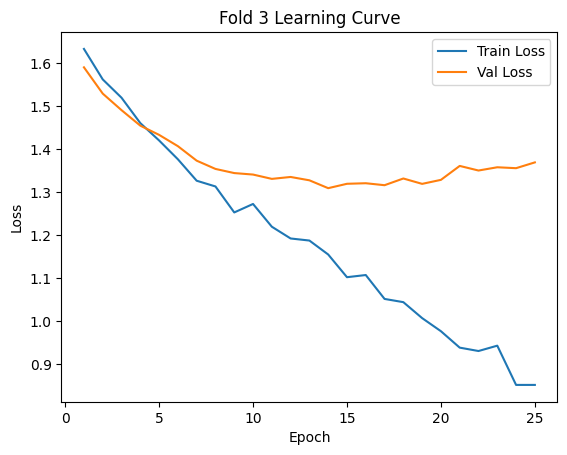

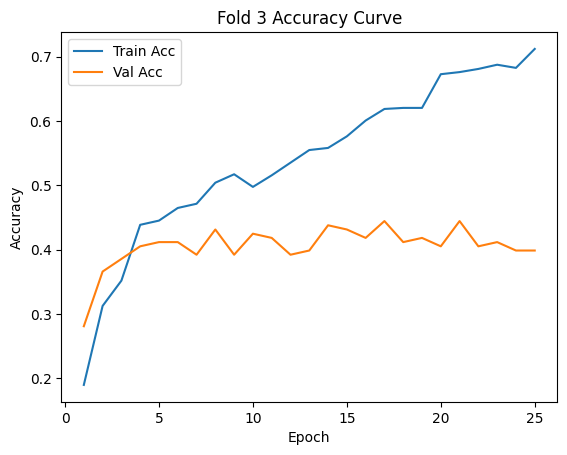

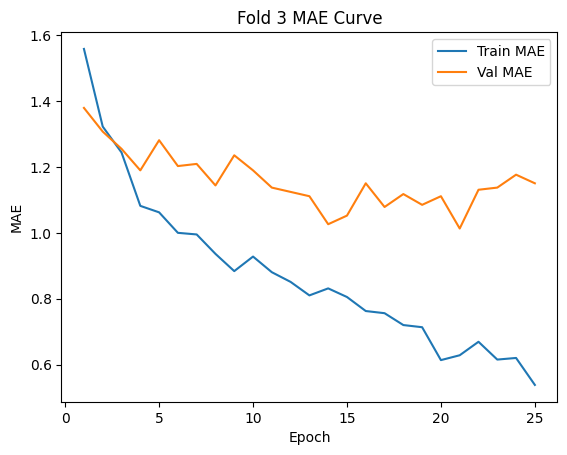

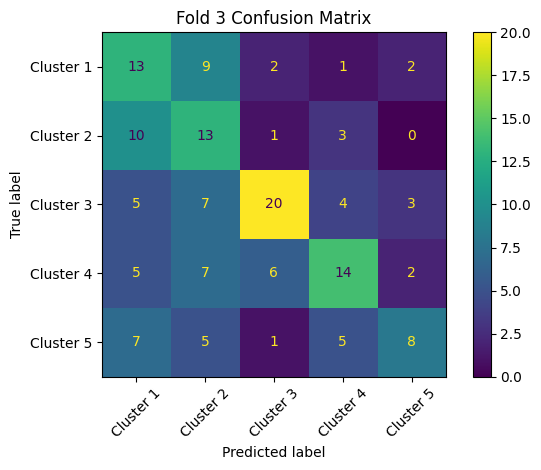


FOLD 4/5
Epoch 1/25: Train Acc=0.2095, Val Acc=0.3268, Val MAE=1.2484, F1=0.3057
Epoch 2/25: Train Acc=0.2700, Val Acc=0.5163, Val MAE=0.9412, F1=0.5096
Epoch 3/25: Train Acc=0.3535, Val Acc=0.5163, Val MAE=0.9346, F1=0.5060
Epoch 4/25: Train Acc=0.3650, Val Acc=0.5425, Val MAE=0.8824, F1=0.5180
Epoch 5/25: Train Acc=0.4173, Val Acc=0.5294, Val MAE=0.9020, F1=0.4960
Epoch 6/25: Train Acc=0.4501, Val Acc=0.5294, Val MAE=0.9020, F1=0.5086
Epoch 7/25: Train Acc=0.4795, Val Acc=0.5359, Val MAE=0.8889, F1=0.5104
Epoch 8/25: Train Acc=0.4648, Val Acc=0.5033, Val MAE=0.9935, F1=0.4798
Epoch 9/25: Train Acc=0.4615, Val Acc=0.5163, Val MAE=0.9085, F1=0.4819
Epoch 10/25: Train Acc=0.4910, Val Acc=0.5229, Val MAE=0.9150, F1=0.5026
Epoch 11/25: Train Acc=0.4959, Val Acc=0.5229, Val MAE=0.8954, F1=0.5009
Early stopping!

Fold 4 Results: Acc=0.5425, MAE=0.8824, Precision=0.5287, Recall=0.5425, F1=0.5180
              precision    recall  f1-score   support

   Cluster 1     0.5000    0.3333    0.40

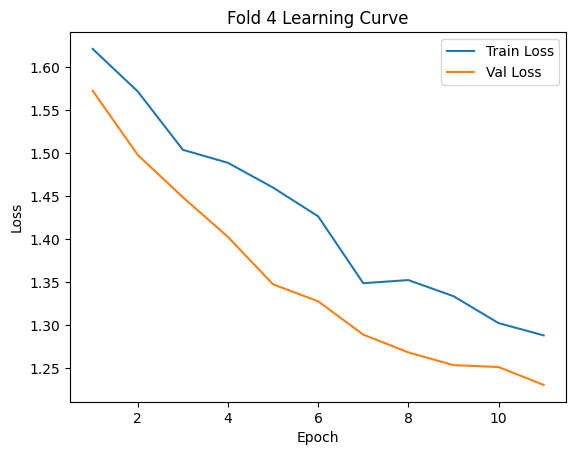

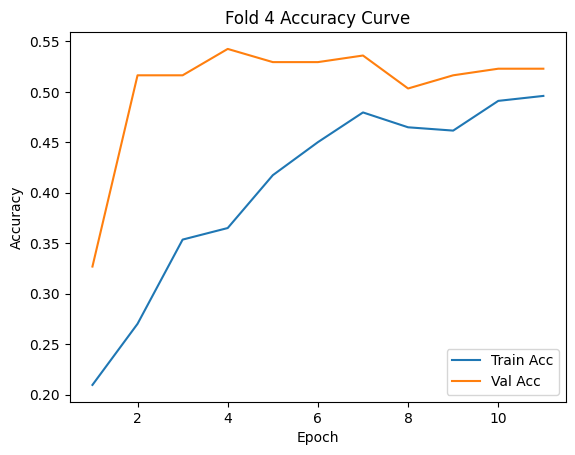

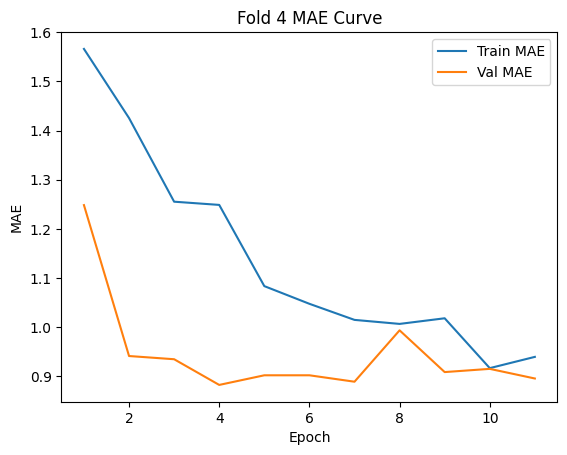

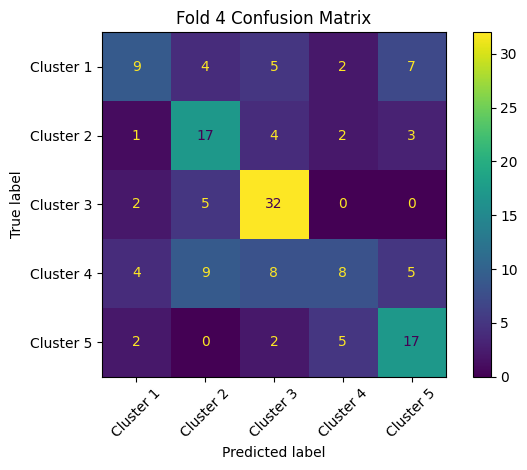


FOLD 5/5
Epoch 1/25: Train Acc=0.2549, Val Acc=0.2961, Val MAE=1.1974, F1=0.2799
Epoch 2/25: Train Acc=0.3464, Val Acc=0.3816, Val MAE=1.0658, F1=0.3731
Epoch 3/25: Train Acc=0.3971, Val Acc=0.3882, Val MAE=1.0987, F1=0.3712
Epoch 4/25: Train Acc=0.4379, Val Acc=0.3684, Val MAE=1.1250, F1=0.3555
Epoch 5/25: Train Acc=0.4428, Val Acc=0.4013, Val MAE=1.0461, F1=0.3669
Epoch 6/25: Train Acc=0.4510, Val Acc=0.4013, Val MAE=1.0526, F1=0.3754
Epoch 7/25: Train Acc=0.4526, Val Acc=0.4079, Val MAE=1.0789, F1=0.3859
Epoch 8/25: Train Acc=0.5065, Val Acc=0.3816, Val MAE=1.2105, F1=0.3639
Epoch 9/25: Train Acc=0.5180, Val Acc=0.3947, Val MAE=1.1974, F1=0.3671
Epoch 10/25: Train Acc=0.5098, Val Acc=0.4145, Val MAE=1.1053, F1=0.4028
Epoch 11/25: Train Acc=0.5425, Val Acc=0.4079, Val MAE=1.0658, F1=0.3917
Epoch 12/25: Train Acc=0.5621, Val Acc=0.4276, Val MAE=1.0461, F1=0.4079
Epoch 13/25: Train Acc=0.5490, Val Acc=0.4408, Val MAE=0.9474, F1=0.4391
Epoch 14/25: Train Acc=0.5997, Val Acc=0.4474, Val

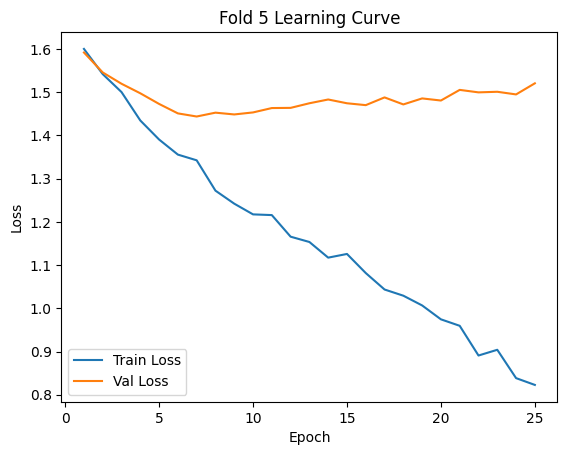

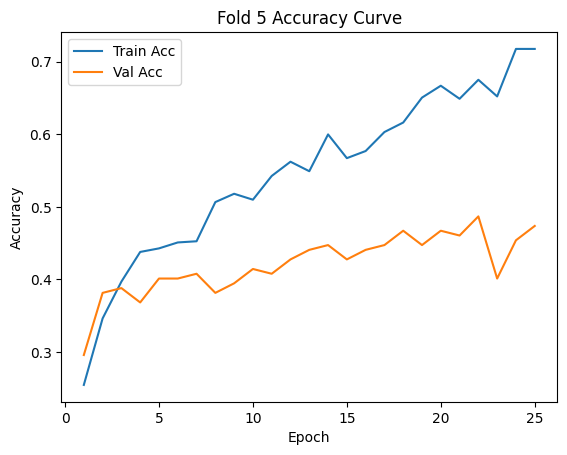

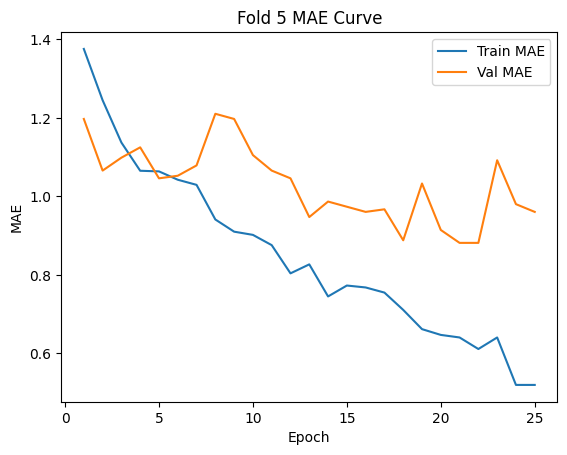

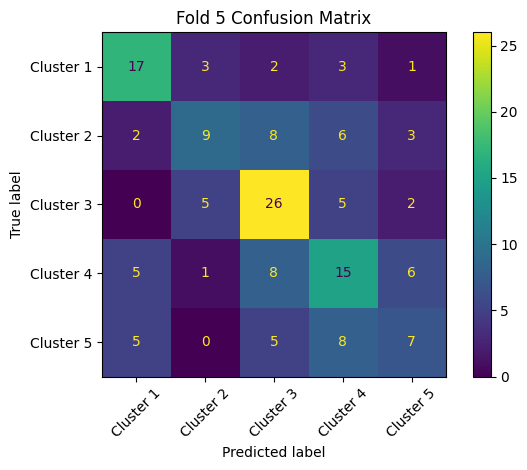


FINAL MULTIMODAL RESULTS
 fold  accuracy      mae  precision   recall       f1
    1  0.483660 0.895425   0.464912 0.483660 0.455804
    2  0.483660 0.895425   0.499485 0.483660 0.481740
    3  0.444444 1.013072   0.489100 0.444444 0.452044
    4  0.542484 0.882353   0.528741 0.542484 0.517960
    5  0.486842 0.881579   0.478976 0.486842 0.475525

Average Performance:
  Accuracy:  0.4882 ± 0.0350
  MAE:       0.9136 ± 0.0560
  Precision: 0.4922 ± 0.0241
  Recall:    0.4882 ± 0.0350
  F1-Score:  0.4766 ± 0.0263


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Catatan:
# Di bawah ini kita override ulang fungsi train_epoch dan evaluate
# supaya juga mengembalikan MAE per epoch.

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    for batch in dataloader:
        lyrics = batch['lyrics_emb'].to(device)
        audio = batch['audio_emb'].to(device)
        midi = batch['midi_feat'].to(device)
        has_l = batch['has_lyrics'].to(device)
        has_a = batch['has_audio'].to(device)
        has_m = batch['has_midi'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(lyrics, audio, midi, has_l, has_a, has_m)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    mae = np.mean(np.abs(np.array(predictions) - np.array(true_labels)))
    return total_loss / len(dataloader), acc, mae


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            lyrics = batch['lyrics_emb'].to(device)
            audio = batch['audio_emb'].to(device)
            midi = batch['midi_feat'].to(device)
            has_l = batch['has_lyrics'].to(device)
            has_a = batch['has_audio'].to(device)
            has_m = batch['has_midi'].to(device)
            labels = batch['label'].to(device)

            logits = model(lyrics, audio, midi, has_l, has_a, has_m)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    mae = np.mean(np.abs(np.array(predictions) - np.array(true_labels)))
    p, r, f1, _ = precision_recall_fscore_support(true_labels, predictions,
                                                 average='weighted', zero_division=0)
    return total_loss / len(dataloader), acc, mae, p, r, f1, predictions, true_labels


# 5-FOLD CV + PLOT LOSS, ACC, MAE, DAN CONFUSION MATRIX

BATCH_SIZE = 16
LR = 5e-5
EPOCHS = 25
PATIENCE = 7

print("\n" + "="*80)
print("MULTIMODAL FUSION - 5-FOLD CROSS VALIDATION DENGAN MAE")
print("="*80)
print(f"Total samples: {len(df)}")
print("Modalities: Lyrics (768) + Audio (2048) + MIDI (32)")

X = df.index.values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n{'='*80}")
    print(f"FOLD {fold + 1}/5")
    print(f"{'='*80}")

    train_data = df.iloc[train_idx].reset_index(drop=True)
    val_data = df.iloc[val_idx].reset_index(drop=True)

    train_dataset = MultimodalDataset(train_data)
    val_dataset = MultimodalDataset(val_data)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = MultimodalFusionClassifier(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=3)

    best_f1 = 0
    patience_counter = 0

    # history untuk plot
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_maes, val_maes = [], []

    for epoch in range(EPOCHS):
        train_loss, train_acc, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_mae, val_p, val_r, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_f1)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_maes.append(train_mae)
        val_maes.append(val_mae)

        print(f"Epoch {epoch+1}/{EPOCHS}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Val MAE={val_mae:.4f}, F1={val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f'best_multimodal_fold{fold+1}.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping!")
                break

    # pakai model terbaik untuk evaluasi dan confusion matrix
    model.load_state_dict(torch.load(f'best_multimodal_fold{fold+1}.pt'))
    val_loss, val_acc, val_mae, val_p, val_r, val_f1, preds, labels = evaluate(model, val_loader, criterion, device)

    print(f"\nFold {fold+1} Results: Acc={val_acc:.4f}, MAE={val_mae:.4f}, Precision={val_p:.4f}, Recall={val_r:.4f}, F1={val_f1:.4f}")
    print(classification_report(labels, preds, target_names=label_encoder.classes_, digits=4, zero_division=0))

    fold_results.append({'fold': fold+1,
                         'accuracy': val_acc,
                         'mae': val_mae,
                         'precision': val_p,
                         'recall': val_r,
                         'f1': val_f1})

    # PLOT LEARNING CURVE (Loss)
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold+1} Learning Curve')
    plt.legend()
    plt.show()

    # PLOT AKURASI
    plt.figure()
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold+1} Accuracy Curve')
    plt.legend()
    plt.show()

    # PLOT MAE
    plt.figure()
    plt.plot(epochs_range, train_maes, label='Train MAE')
    plt.plot(epochs_range, val_maes, label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title(f'Fold {fold+1} MAE Curve')
    plt.legend()
    plt.show()

    # CONFUSION MATRIX UNTUK FOLD INI
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(xticks_rotation=45)
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.tight_layout()
    plt.show()

# HASIL AKHIR
print("\n" + "="*80)
print("FINAL MULTIMODAL RESULTS")
print("="*80)

results_df = pd.DataFrame(fold_results)
print(results_df.to_string(index=False))

print("\nAverage Performance:")
print(f"  Accuracy:  {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"  MAE:       {results_df['mae'].mean():.4f} ± {results_df['mae'].std():.4f}")
print(f"  Precision: {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
print(f"  Recall:    {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
print(f"  F1-Score:  {results_df['f1'].mean():.4f} ± {results_df['f1'].std():.4f}")